In [94]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [96]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [97]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [98]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
#     print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
#     print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [99]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [100]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [101]:
def load_data(path, delimiter, start_time, main_col, target_length=-1):
    # remove any leading or trailing 0s based on the main information column    
    data = np.genfromtxt(path, delimiter=delimiter)
    if data.ndim == 1:
        data = data.reshape((data.shape[0],1))
#     print("initial data shape ", data.shape)
#     print("initial first time ", data[0,0])
#     print("initial last time ", data[data.shape[0]-1,0]) 
    tmp = np.trim_zeros(data[:,main_col], trim='b')
    data = data[:tmp.shape[0],:]
    tmp = np.trim_zeros(data[:,main_col], trim='f')
    data = data[data.shape[0] - tmp.shape[0]:,:]
    
    data = data[data[:,0]>=start_time]
    if target_length != -1:
        data = data[data.shape[0]-target_length:,:]
#     print("data shape ", data.shape)
#     print("first time ", data[0,0])
#     print("last time ", data[data.shape[0]-1,0])  
    
    return data

In [102]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 1 at 30% - 10 flows

In [103]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 0.6


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(81313,)
/TCP/
Mean Q length in Kbytes 0.00027830001714050043 and in packets 0.0032138287486653534
99th percentile in Kbytes 0.0010128430385459041 and in packets 0.0116916624058716

Mean delay in us 0.0022264001371240035 and 99th percentile delay in us 0.008102744308367233

Fanout max QCT (ms): mean: 0.15597286311956107, 99th %: 0.3229161255627134

Fanout avg QCT (ms): mean: 0.15088484678636174, 99th %: 0.31787612556136946

Fanout min QCT (ms): mean: 0.14579641408677385, 99th %: 0.3128361255600255

Servers in deadline: mean: 10.0, 99th %: 10.0

(81313,)
/DCTCP30/
Mean Q length in Kbytes 0.00027830001714050043 and in packets 0.0032138287486653534
99th percentile in Kbytes 0.0010128430385459041 and in packets 0.0116916624058716

Mean delay in us 0.0022264001371240035 and 99th percentile delay in us 0.008102744308367233

Fanout max QCT (ms): mean: 0.15597286311956107, 99th %: 0.3229161255627134

Fanout avg QCT (ms): mean: 0.15088484678636174, 99th %: 0.31787612556136946

Fanout min QCT (m

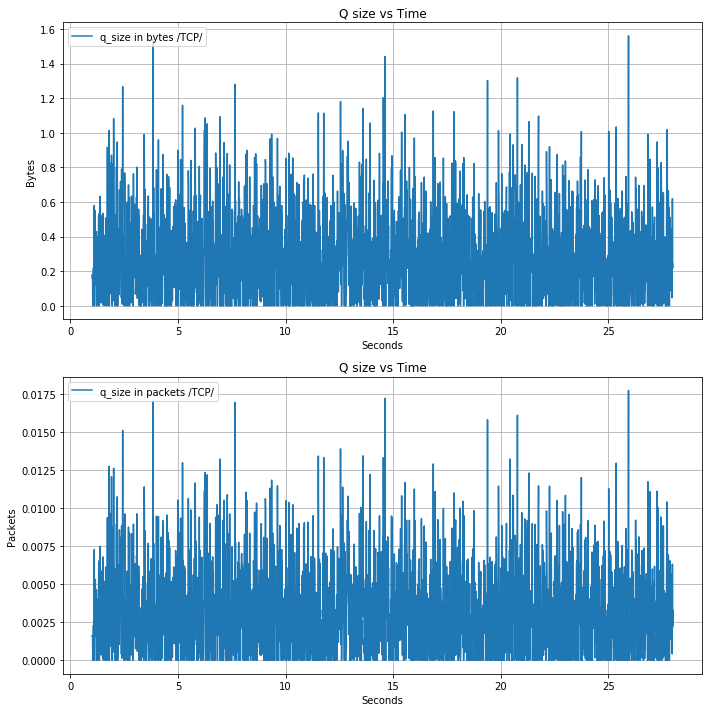

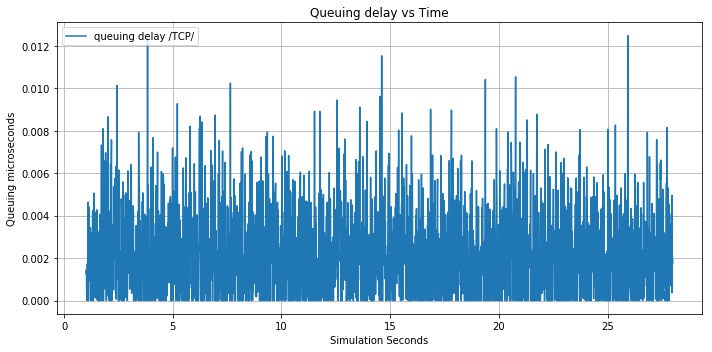

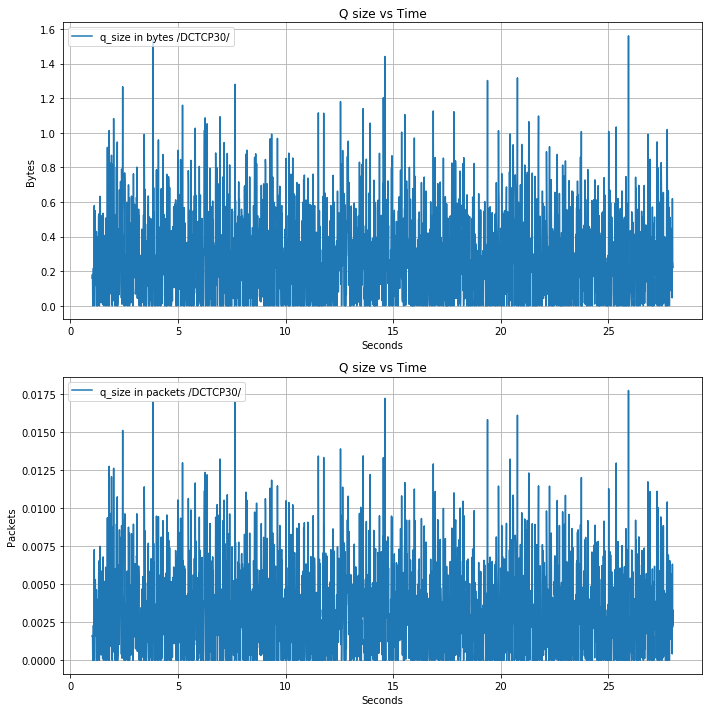

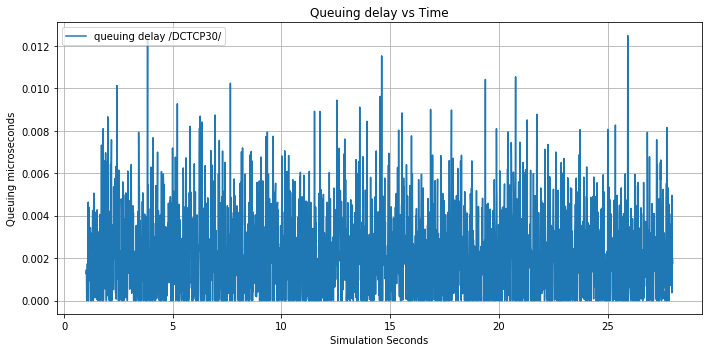

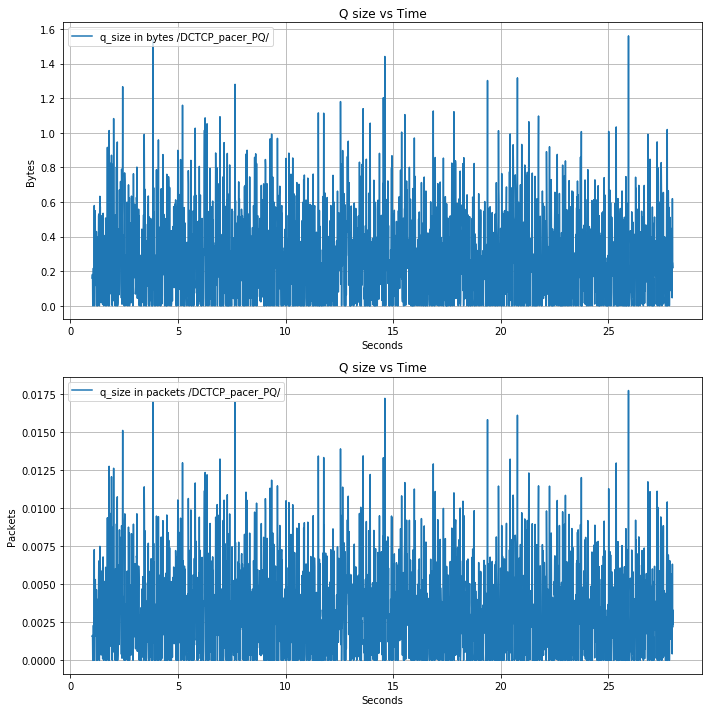

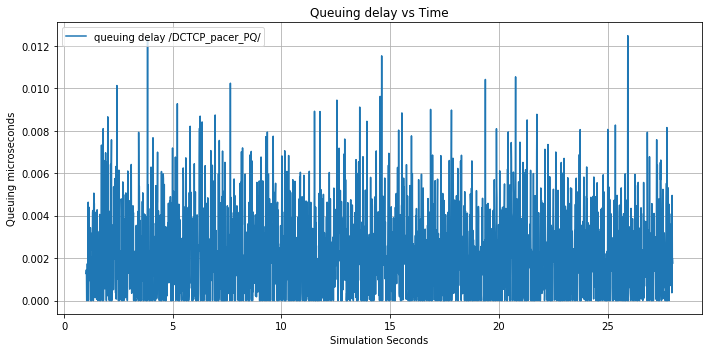

In [104]:
simul_folder = "onlyfanout_wkld0_30_10flows"
stable_state_offset = 0
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    

    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=False, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    nothing ever
    """

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(69309,)
/TCP/
Mean Q length in Kbytes 25.06749433003542 and in packets 36.530724565644654
99th percentile in Kbytes 227.6105548720219 and in packets 331.63950949733237

Mean delay in us 200.53995464028336 and 99th percentile delay in us 1820.8844389761753

Background FCT (ms): mean: 116.44130831208284, 99th %: 299.61598279459224

Fanout max QCT (ms): mean: 0.3826723006272853, 99th %: 2.4200956917874805

Fanout avg QCT (ms): mean: 0.3609826120714026, 99th %: 2.070138052114223

Fanout min QCT (ms): mean: 0.3516576860718069, 99th %: 2.042600157611005

Servers in deadline: mean: 8.077940815767072, 99th %: 0.0

(69309,)
/DCTCP30/
Mean Q length in Kbytes 6.171212715375259 and in packets 9.064170239142225
99th percentile in Kbytes 30.16192599297015 and in packets 47.494205719182574

Mean delay in us 49.36970172300207 and 99th percentile delay in us 241.2954079437612

Background FCT (ms): mean: 119.50578200807723, 99th %: 290.9782663947709

Fanout max QCT (ms): mean: 0.21376002314560752, 99th

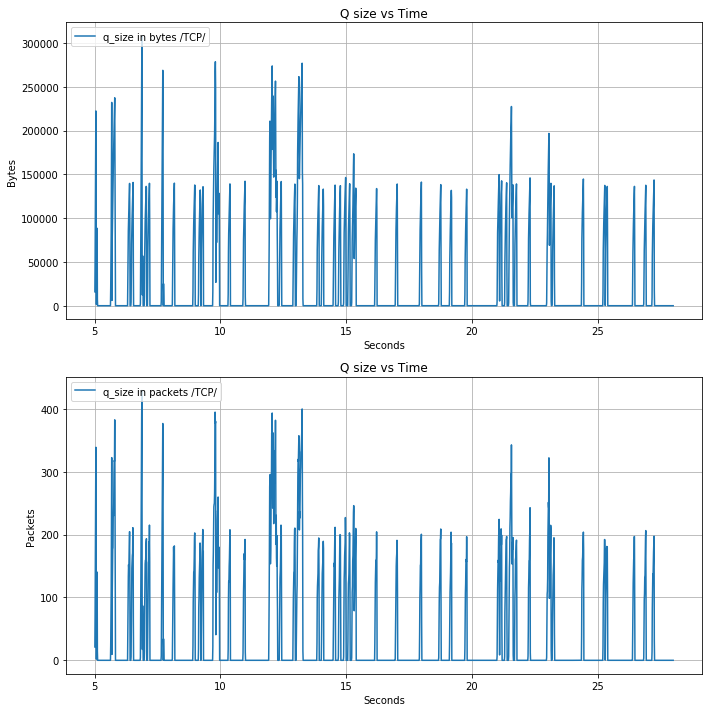

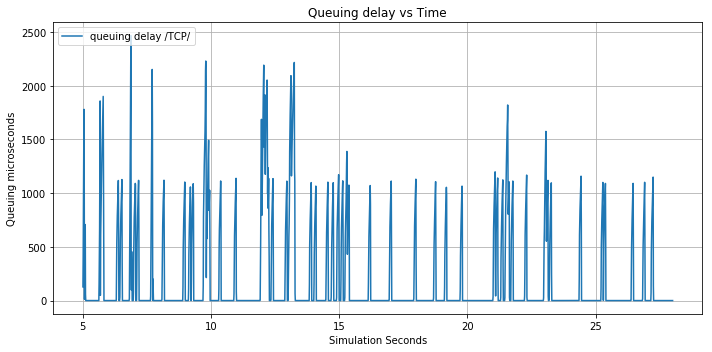

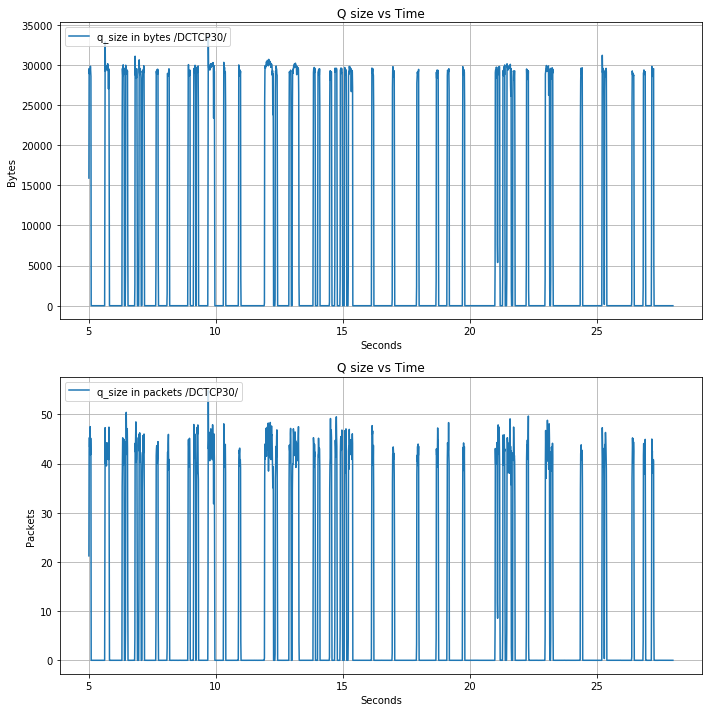

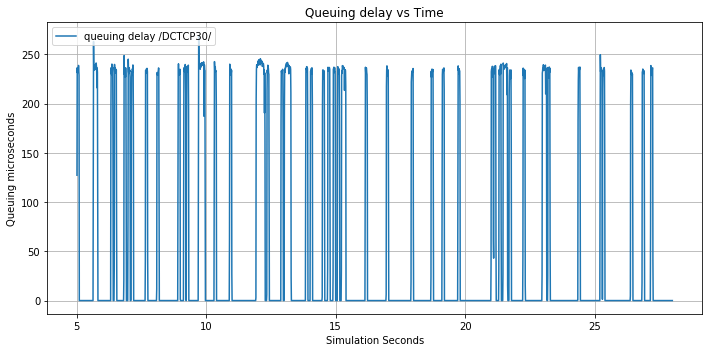

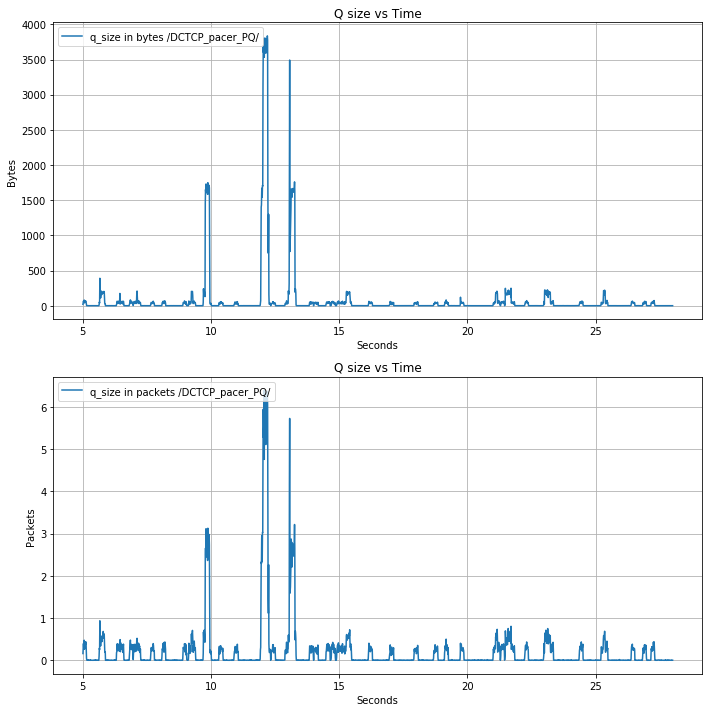

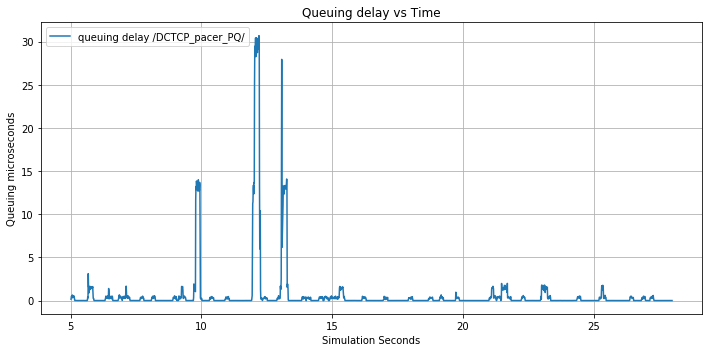

In [105]:
simul_folder = "bkg200_fanout_wkld0_30_10flows"
stable_state_offset = 5
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,190)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,14592)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,107)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 1 at 30% + background traffic at 400Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(72311,)
/TCP/
Mean Q length in Kbytes 65.46377871621122 and in packets 94.87788128828971
99th percentile in Kbytes 274.3610194781795 and in packets 399.01737990643215

Mean delay in us 523.7102297296898 and 99th percentile delay in us 2194.888155825436

Background FCT (ms): mean: 156.33269933860518, 99th %: 505.3801034077898

Fanout max QCT (ms): mean: 0.7015913455852159, 99th %: 2.4501543101401055

Fanout avg QCT (ms): mean: 0.684788505218429, 99th %: 2.4269110350399536

Fanout min QCT (ms): mean: 0.6730784982670064, 99th %: 2.390558173337973

Servers in deadline: mean: 5.569526074871043, 99th %: 0.0

(72311,)
/DCTCP30/
Mean Q length in Kbytes 14.16947585623369 and in packets 20.717241217902725
99th percentile in Kbytes 30.86429413443943 and in packets 48.367985830968756

Mean delay in us 113.35580684986952 and 99th percentile delay in us 246.9143530755154

Background FCT (ms): mean: 161.7259344148973, 99th %: 468.5079649816473

Fanout max QCT (ms): mean: 0.28338046801476874, 99th %:

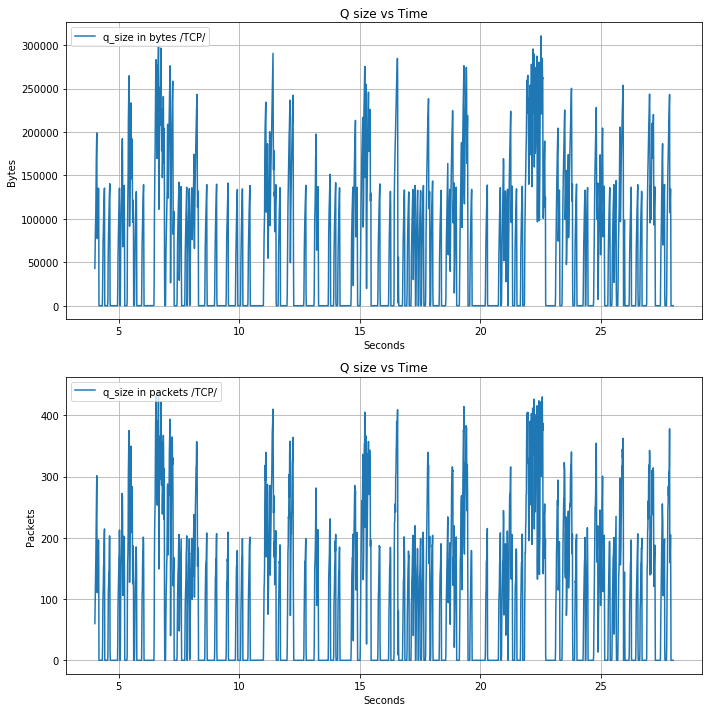

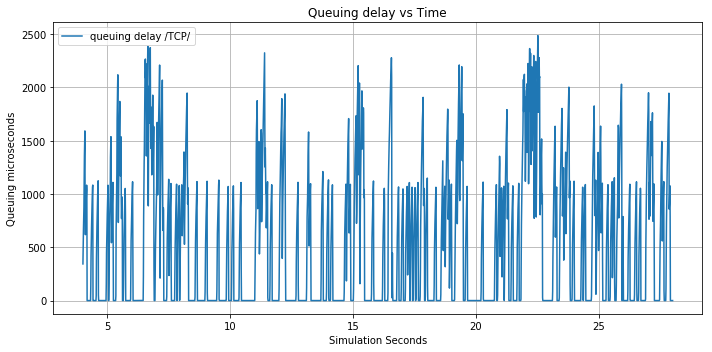

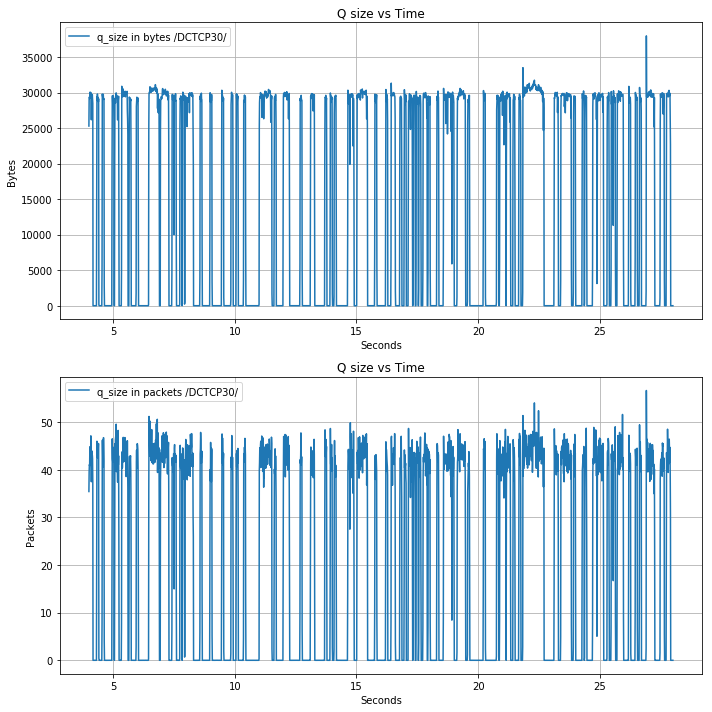

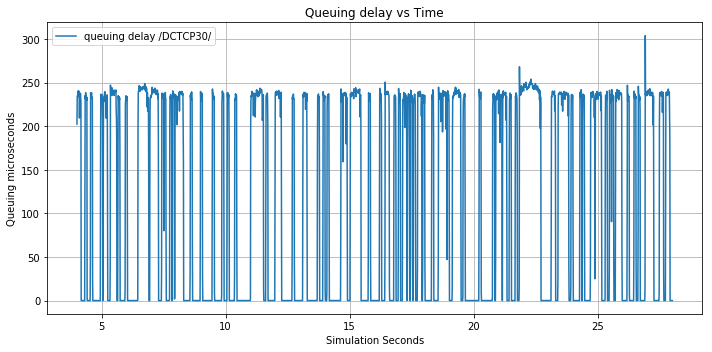

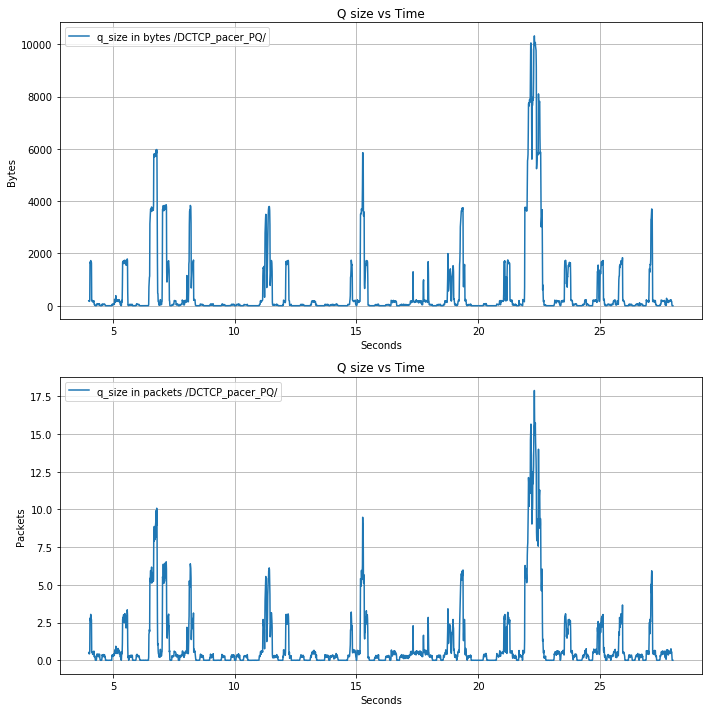

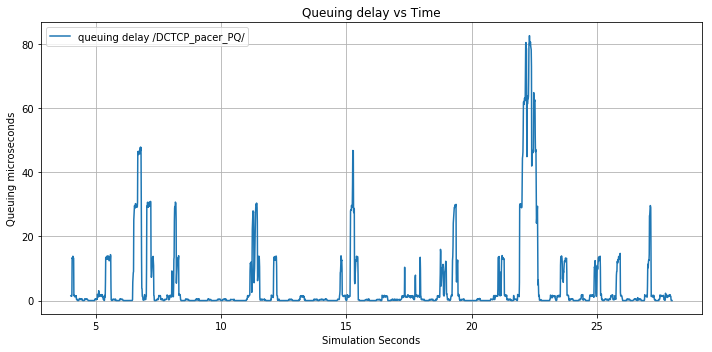

In [106]:
simul_folder = "bkg400_fanout_wkld0_30_10flows"

stable_state_offset = 4
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1028)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38172)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,544)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,68)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 1 at 30% + background traffic at 600Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(75278,)
/TCP/
Mean Q length in Kbytes 109.56835944908839 and in packets 158.59080870059137
99th percentile in Kbytes 289.4774986430929 and in packets 419.45915843096145

Mean delay in us 876.5468755927074 and 99th percentile delay in us 2315.8199891447434

Background FCT (ms): mean: 218.74603368501747, 99th %: 669.9723791863236

Fanout max QCT (ms): mean: 1.3783953508877533, 99th %: 4.730907825247975

Fanout avg QCT (ms): mean: 1.1436391063929212, 99th %: 3.981576222332508

Fanout min QCT (ms): mean: 1.03240355713248, 99th %: 2.576426820611175

Servers in deadline: mean: 3.4877254974893064, 99th %: 0.0

(75278,)
/DCTCP30/
Mean Q length in Kbytes 20.49302770962072 and in packets 29.934895739445935
99th percentile in Kbytes 31.470761510817606 and in packets 49.83969577711981

Mean delay in us 163.94422167696575 and 99th percentile delay in us 251.76609208654085

Background FCT (ms): mean: 228.98574222595272, 99th %: 631.8284295585659

Fanout max QCT (ms): mean: 0.33676859437356677, 99th

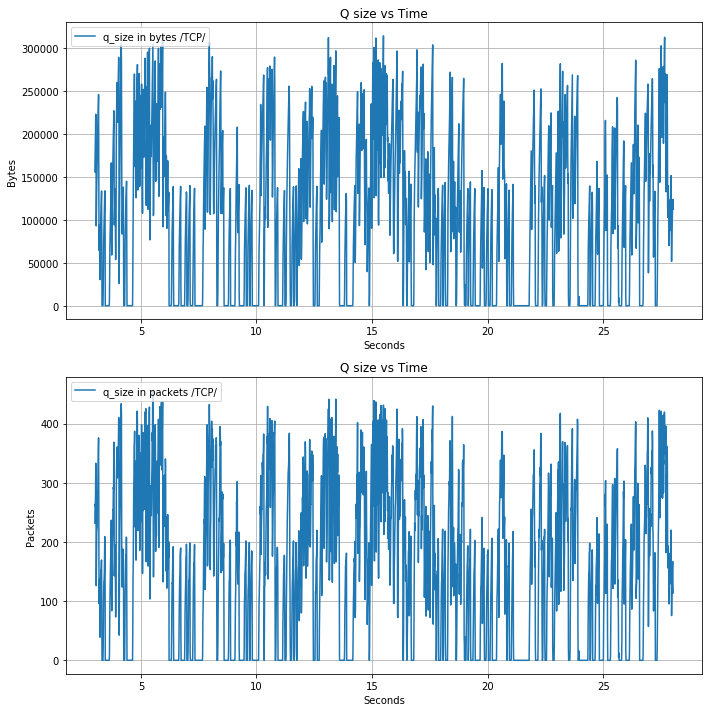

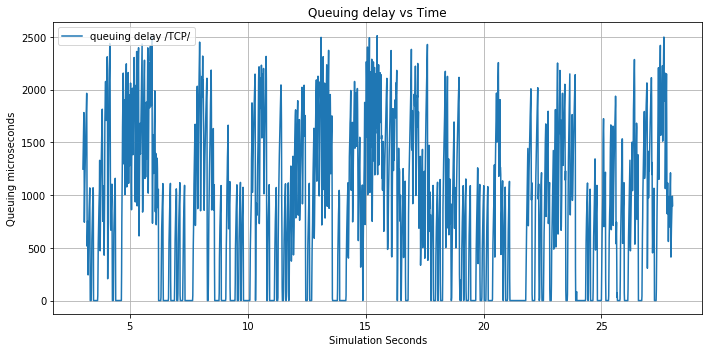

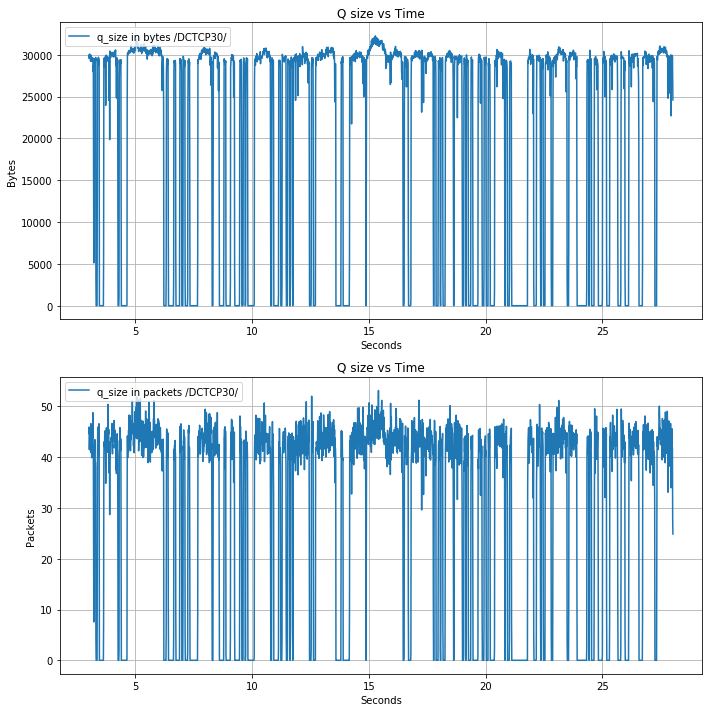

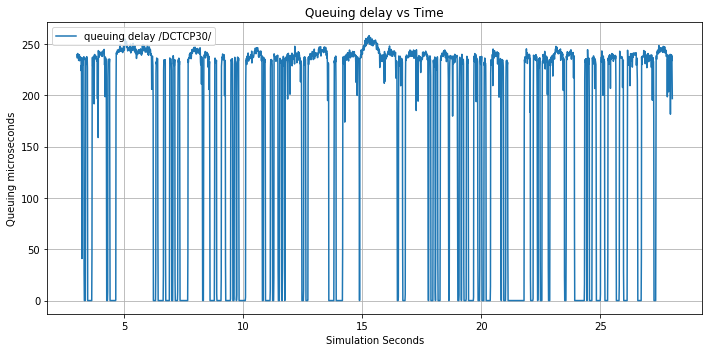

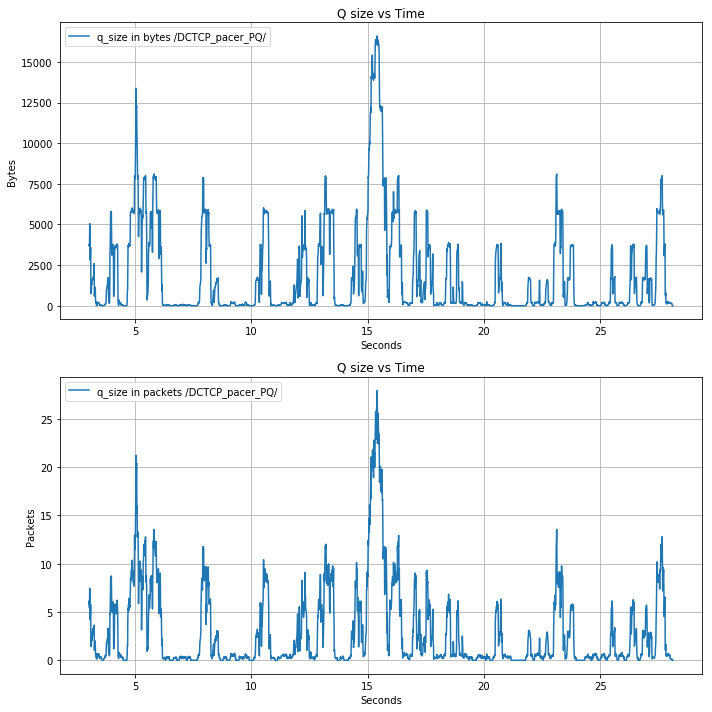

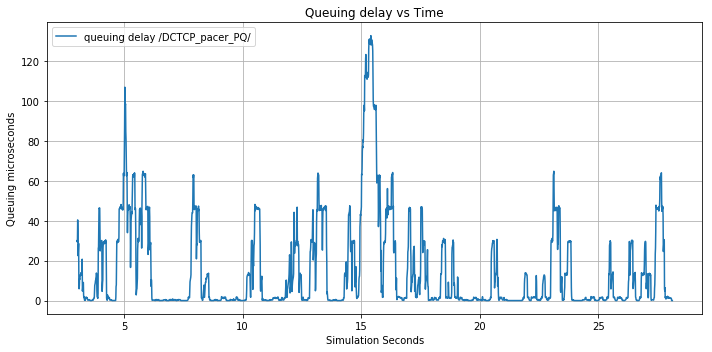

In [107]:
simul_folder = "bkg600_fanout_wkld0_30_10flows"

stable_state_offset = 3
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2439)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,72058)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1344)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

In [108]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(0.0022264001371240035, 0.008102744308367233), (200.53995464028336, 1820.8844389761753), (523.7102297296898, 2194.888155825436), (876.5468755927074, 2315.8199891447434)], '/DCTCP30/': [(0.0022264001371240035, 0.008102744308367233), (49.36970172300207, 241.2954079437612), (113.35580684986952, 246.9143530755154), (163.94422167696575, 251.76609208654085)], '/DCTCP_pacer_PQ/': [(0.0022264001371240035, 0.008102744308367233), (0.6896864334834526, 13.848592057620246), (4.617892002031342, 62.62781217221816), (15.054828941073172, 113.14311909305303)]}
--------bkg----------
{'/TCP/': [(116.44130831208284, 299.61598279459224), (156.33269933860518, 505.3801034077898), (218.74603368501747, 669.9723791863236)], '/DCTCP30/': [(119.50578200807723, 290.9782663947709), (161.7259344148973, 468.5079649816473), (228.98574222595272, 631.8284295585659)], '/DCTCP_pacer_PQ/': [(185.6207988157715, 311.64081253554144), (239.24237083005156, 508.96016234501263), (310.0900773670

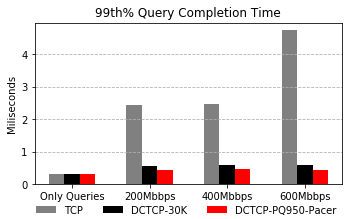

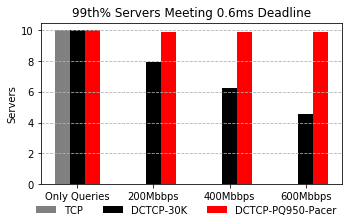

In [110]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
config_num = 4
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('Only Queries', '200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])

p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th% Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()



fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th% Servers Meeting 0.6ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")





fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()